In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "training_models"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)

def save_fig(fig_id, tight_layout=True):
    # cwd = os.getcwd() + "images"
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    # mode = "a" if os.path.exists(path) else "w"
    print("saving figure", fig_id)
    # 新建目录 不然也会报错
    # 新建png文件 不然找不到该文件会报错 chapter_id 手动创建
    if not os.path.isdir(os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)):
        os.makedirs(os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID))
    if not os.path.exists(path):
        with open(path, 'w'):
            pass
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format="png", dpi=300)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

### Linear Regression 
$\hat{y} = \theta_0 + \theta_1x_1 + \theta_2x_2+\cdot\cdot\cdot+\theta_nx_n = h_\boldsymbol{\theta}(\textbf{x})=\boldsymbol{\theta} \cdot \textbf{x}$
* $\hat{y}$: 预测值
* n: 特征数
* $x_i$是$i^{th}$特征值
* $\theta_j$是模型的参数值，$\theta_0$是偏差项(bias term)，剩下的是特征的权值
* 后面的是矢量形式，$\theta$包含了偏差项$\theta_0$，**x**的第一个元素是1
* ML中，矢量一般指的是列矢量，即2d array: n*1，then $\hat{y} = \theta^\textbf{T}\textbf{x}$是矩阵相乘，结果是个只要一个元素的矩阵

<br>**线性回归模型的MSE损失函数:** $MSE(\textbf{X}, h_\theta) = \frac{1}{m}\sum\limits_{i=1}^{m}(\theta^{T}x^{(i)}-y^{(i)})^2$ (X: instances, $h_\theta$: hypothesis(pred. func) with paremeters $\theta$
<br>**Normal Equation**: $\hat{\theta}=(\mathbf{X}^{T}\mathbf{X})^{-1} \mathbf{X}^{T} \mathbf{y}$ 
* close-form解，$\hat{\theta}$使MSE取最小值
* y: $y^{(1)}-y^{(m)}$

In [10]:
import numpy as np
X= 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100, 1)
X_b = np.c_[np.ones((100, 1)), X] # add x0=1 to each instance, why?
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

saving figure generated_data_plot


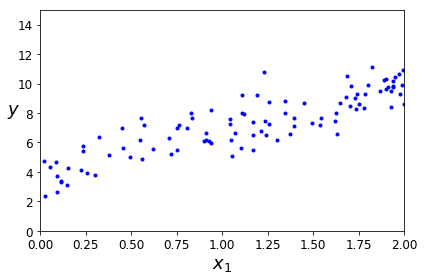

In [9]:
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([0, 2, 0, 15])
save_fig("generated_data_plot")
plt.show()

actual function is: $y=4+3x_1$+ Gaussian noise

In [11]:
X_new = np.array([[0], [2]])
X_new_b = np.c_[np.ones((2, 1)), X_new] # why np.ones?
y_pred = X_new_b.dot(theta_best)

saving figure linear_model_predictions


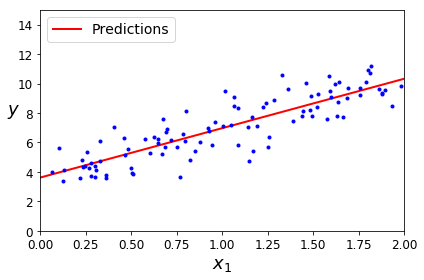

In [14]:
plt.plot(X_new, y_pred, "r-", linewidth=2, label="Predictions")
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.axis([0, 2, 0, 15])
save_fig("linear_model_predictions")
plt.show()

In [102]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_ # shape: (1,) (1,1) bias term vs feature weights
lin_reg

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

LinearRegression基于scipy.linalg.lstsq()函数，即least square，该函数计算的是$\mathbf{X}^+\mathbf{y}$，$\mathbf{X}^+$是广义逆(e.g. Moore-Penrose inverse，矩阵SVD分解)，与Normal Equation相比，计算效率更高，而且Normal Equation中$\mathbf{X^TX}$可能不可逆(m<n, 特征有冗余)，两者在特征数特别多or训练实例很大不能fit内存时应用受限

In [25]:
np.linalg.pinv(X_b).dot(y)

array([[3.61308771],
       [3.35788041]])

#### Gradient Descent
* 通过迭代的方法最小化损失函数
* 凸函数中找到的是全局最优点
* 对特征的scale很敏感 if scale，收敛的速度会大大降低

#### 

#### Batch Gradient Descent
损失函数的偏导数: $\frac{\partial}{\partial\theta_j}MSE(\boldsymbol\theta)=\frac{2}{m_i}\sum\limits_{i = 1}^{m}(\boldsymbol{\theta}^{T}\mathbf{x}^{(i)}-y^{(i)})x_j^{(i)}$
<br>MSE的梯度向量: $\nabla_{\boldsymbol\theta}MSE(\boldsymbol\theta)=\frac{2}{m}\mathbf{X}^T(\mathbf{X}\boldsymbol{\theta}-\mathbf{y})$ 每个训练步都要使用整个样本，batch for whole batch of training data，但是特征数特别多时，比Normal Equation和SVD分解好
<br>梯度下降步：$\boldsymbol\theta^{(next\,step)}=\boldsymbol\theta-\eta\nabla_{\boldsymbol\theta}MSE(\boldsymbol\theta)$　（$\eta$学习率）

In [26]:
eta = 0.1 # 学习率
iterations = 1000
m = 100
theta = np.random.randn(2,1)

for i in range(iterations):
    grad = 2/m *(X_b.T.dot(X_b.dot(theta) - y))
    theta = theta - eta * grad

In [29]:
theta # same with svd result

array([[3.61308771],
       [3.35788041]])

In [64]:
theta_path_bgd = []

def plot_gradient_descent(theta, eta, theta_path=None):
    m = len(X_b)
    plt.plot(X, y, 'b.')
    n_iterations = 1000
    for i in range(n_iterations):
        if(i<10):
            y_pred = X_new_b.dot(theta)
            style = 'b-' if i > 0 else 'r--'
            plt.plot(X_new, y_pred, style)
        gradients = 2/m * (X_b.T.dot(X_b.dot(theta) - y)) # use whole batch
        theta = theta - eta * gradients
        if theta_path is not None:
            theta_path.append(theta)
    plt.xlabel('$x_1$', fontsize=18)
    plt.axis([0,2,0,15])
    plt.title(f"$\eta={eta}$", fontsize=16)

saving figure gradient_descent_plot


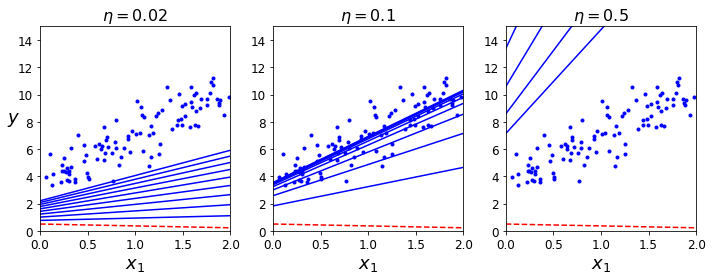

In [65]:
np.random.seed(42)
theta = np.random.randn(2,1)
plt.figure(figsize=(10,4))
plt.subplot(131); plot_gradient_descent(theta, eta=0.02)
plt.ylabel('$y$', rotation=0, fontsize=18)
plt.subplot(132); plot_gradient_descent(theta, eta=0.1, theta_path=theta_path_bgd)
plt.subplot(133); plot_gradient_descent(theta, eta=0.5)

save_fig('gradient_descent_plot')
plt.show()

#### Stochastic Gradient Descent

saving figure sgd_plot


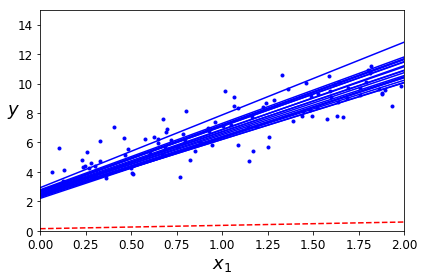

In [45]:
theta_path_sgd = []
n_epochs = 50
t0, t1 = 5, 50  # learning schedule hyperparameters

def learning_schedule(t):
    return t0 / (t + t1)

theta = np.random.randn(2,1)  # random initialization

for epoch in range(n_epochs):
    for i in range(m):
        if epoch == 0 and i < 20:                    # not shown in the book
            y_predict = X_new_b.dot(theta)           # not shown
            style = "b-" if i > 0 else "r--"         # not shown
            plt.plot(X_new, y_predict, style)        # not shown
        random_index = np.random.randint(m)
        xi = X_b[random_index:random_index+1]
        yi = y[random_index:random_index+1]
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi) # xi: (1,2) just use one instance at a time!
        eta = learning_schedule(epoch * m + i)
        theta = theta - eta * gradients
        theta_path_sgd.append(theta)                 # not shown

plt.plot(X, y, "b.")                                 # not shown
plt.xlabel("$x_1$", fontsize=18)                     # not shown
plt.ylabel("$y$", rotation=0, fontsize=18)           # not shown
plt.axis([0, 2, 0, 15])                              # not shown
save_fig("sgd_plot")                                 # not shown
plt.show()     

In [60]:
theta

array([[3.57096225],
       [3.36897237]])

In [58]:
from sklearn.linear_model import SGDRegressor

sgd_reg = SGDRegressor(max_iter=50, tol=-np.infty, penalty=None, eta0=0.1, random_state=42)
sgd_reg.fit(X, y.ravel()) # y.ravel() 压平成1d数组

SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
       eta0=0.1, fit_intercept=True, l1_ratio=0.15,
       learning_rate='invscaling', loss='squared_loss', max_iter=50,
       n_iter=None, n_iter_no_change=5, penalty=None, power_t=0.25,
       random_state=42, shuffle=True, tol=-inf, validation_fraction=0.1,
       verbose=0, warm_start=False)

In [59]:
sgd_reg.intercept_, sgd_reg.coef_

(array([3.65980607]), array([3.41046967]))

#### Mini-batch Gradient Descent
每次既不是选取整个batch，也不是选一个实例，而是随机选择训练集中的一个子集(mini-batch)

In [61]:
theta_path_mgd = []

n_iterations = 50
minibatch_size = 20

np.random.seed(42)
theta = np.random.randn(2,1)  # random initialization

t0, t1 = 200, 1000
def learning_schedule(t):
    return t0 / (t + t1)

t = 0
for epoch in range(n_iterations):
    shuffled_indices = np.random.permutation(m)
    X_b_shuffled = X_b[shuffled_indices]
    y_shuffled = y[shuffled_indices]
    for i in range(0, m, minibatch_size):
        t += 1
        xi = X_b_shuffled[i:i+minibatch_size]
        yi = y_shuffled[i:i+minibatch_size]
        gradients = 2/minibatch_size * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(t)
        theta = theta - eta * gradients
        theta_path_mgd.append(theta)

In [67]:
theta_path_bgd = np.array(theta_path_bgd)
theta_path_sgd = np.array(theta_path_sgd)
theta_path_mgd = np.array(theta_path_mgd)

saving figure gradient_descent_paths_plot


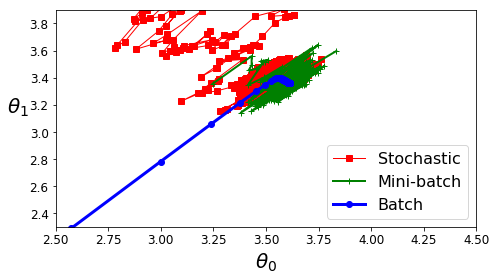

In [70]:
plt.figure(figsize=(7,4))
plt.plot(theta_path_sgd[:, 0], theta_path_sgd[:, 1], "r-s", linewidth=1, label="Stochastic")
plt.plot(theta_path_mgd[:, 0], theta_path_mgd[:, 1], "g-+", linewidth=2, label="Mini-batch")
plt.plot(theta_path_bgd[:, 0], theta_path_bgd[:, 1], "b-o", linewidth=3, label="Batch")
plt.legend(loc="lower right", fontsize=16)
plt.xlabel(r"$\theta_0$", fontsize=20)
plt.ylabel(r"$\theta_1$   ", fontsize=20, rotation=0)
plt.axis([2.5, 4.5, 2.3, 3.9])
save_fig("gradient_descent_paths_plot")
plt.show()

#### Polynominal Regression: 将每个feature加上次方并组合，构成新的features

In [74]:
import numpy as np
np.random.seed(42) # keep results same

m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X ** 2 + X + 2 + np.random.randn(m, 1)

saving figure quadratic_data_plot


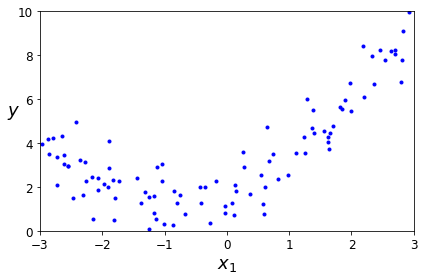

In [75]:
plt.plot(X, y, 'b.')
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", fontsize=18, rotation=0)
plt.axis([-3, 3, 0, 10])
save_fig('quadratic_data_plot')
plt.show()

In [107]:
from sklearn.preprocessing import PolynomialFeatures

poly_features = PolynomialFeatures(degree=2, include_bias=False) # 不加偏差项，后面的LR会处理
X_poly = poly_features.fit_transform(X) # 特征提取，原来的X只有1个特征x1，处理后-> (x, x^2) 两特征

In [108]:
test = poly_features.fit_transform(X) # fit 只是更新了class的attributes transform后才多出来features
test.shape

(100, 2)

In [77]:
X[0], X_poly[0]

(array([-0.75275929]), array([-0.75275929,  0.56664654]))

In [79]:
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_ # 截距，特征权值（一次项，二次项）

(array([1.78134581]), array([[0.93366893, 0.56456263]]))

saving figure quadratic_predictions_plot


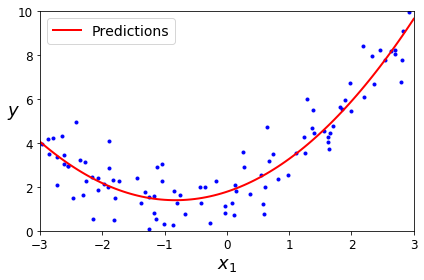

In [80]:
X_new=np.linspace(-3, 3, 100).reshape(100, 1) # pred. curve, 2d array, 100个点
X_new_poly = poly_features.transform(X_new) # 先预处理 提出特征
y_new = lin_reg.predict(X_new_poly)
plt.plot(X, y, "b.")
plt.plot(X_new, y_new, "r-", linewidth=2, label="Predictions")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14) # loc: upper & lower...
plt.axis([-3, 3, 0, 10])
save_fig("quadratic_predictions_plot")
plt.show()

In [89]:
a = np.linspace(1,2,101).reshape(-1, 1) # -1 for 自己算
a.shape

(101, 1)

saving figure high_degree_poly_plot


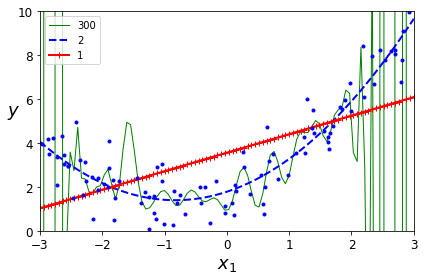

In [90]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

for style, width, degree in(('g-', 1, 300), ('b--', 2, 2), ('r-+', 2, 1)):
    poly_features = PolynomialFeatures(degree=degree, include_bias=False)
    std_scaler = StandardScaler()
    lin_reg = LinearRegression()
    poly_regression = Pipeline([
        ('poly_features', poly_features),
        ('std_scaler', std_scaler),
        ('lin_reg', lin_reg)
    ])
    poly_regression.fit(X, y)
    y_newbig = poly_regression.predict(X_new)
    plt.plot(X_new, y_newbig, style, label=str(degree), linewidth=width)

plt.plot(X, y, 'b.', linewidth=3)
plt.legend(loc='upper left')
plt.xlabel('$x_1$', fontsize=18)
plt.ylabel('$y$', rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])
save_fig('high_degree_poly_plot')
plt.show()

In [99]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=10)
    train_errors, val_errors = [], []
    for i in range(1, len(X_train)):
        model.fit(X_train[:i], y_train[:i])
        y_train_pred = model.predict(X_train[:i])
        y_val_pred = model.predict(X_val) # predict all val. data
        train_errors.append(mean_squared_error(y_train[:i], y_train_pred))
        val_errors.append(mean_squared_error(y_val, y_val_pred))
    plt.plot(np.sqrt(train_errors), 'r-+', linewidth=2, label='train')
    plt.plot(np.sqrt(val_errors), 'b-', linewidth=3, label='val')
    plt.legend(loc='upper right')
    plt.xlabel('Training set size', fontsize=14)
    plt.ylabel('RMSE', fontsize=14)

saving figure underfitting_learning_curve_plot


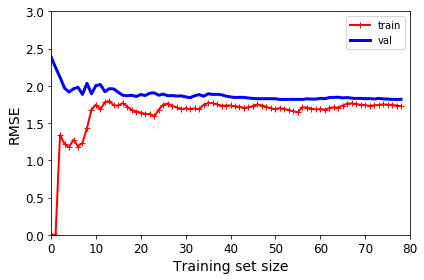

In [100]:
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y)
plt.axis([0, 80, 0, 3])
save_fig('underfitting_learning_curve_plot')
plt.show()

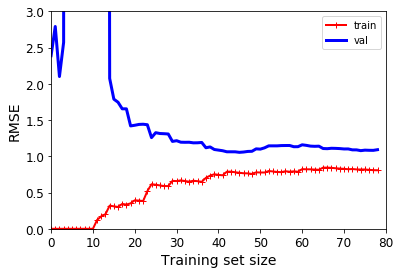

In [101]:
from sklearn.pipeline import Pipeline

poly_reg = Pipeline([
    ('poly_features', PolynomialFeatures(degree=10, include_bias=False)),
    ('lin_reg', LinearRegression())
])
plot_learning_curves(poly_reg, X, y)
plt.axis([0, 80, 0, 3])
plt.show() # 模型的特征变多了后，一开始明显过拟合，但是随着训练集的增加，RMSE最终小于上面的

#### Regularized models

In [109]:
np.random.seed(42)
m = 20
X = 3 * np.random.rand(m, 1)
y = 1 + 0.5 * X + np.random.randn(m, 1) / 1.5
X_new = np.linspace(0, 3, 100).reshape(100, 1)

In [131]:
def plot_model(model_class, polynomial, alphas, **kargs):
    for alpha, style in zip(alphas, ('b-', 'g--', 'r:')):
        model = model_class(alpha, **kargs) if alpha > 0 else LinearRegression()
        if polynomial:
            model = Pipeline([
                ('poly_features', PolynomialFeatures(degree=10, include_bias=False)),
                ('std_scaler', StandardScaler()),
                ('regul_reg', model)
            ])
        model.fit(X, y) # get了回归model的params: intercept_, coef_
        y_new_regul = model.predict(X_new) # pipeline中除了最后一个是predictor外，前面都是tramsformer
        lw = 2 if alpha > 0 else 1
        plt.plot(X_new, y_new_regul, style, linewidth=lw, label=r"$\alpha = {}$".format(alpha)) # f-string里面有$$报错
    plt.plot(X, y, 'b.', linewidth=3)
    plt.legend(loc='upper left', fontsize=15)
    plt.xlabel('$x_1$', fontsize=18)
    plt.axis([0, 3, 0, 4])

Ridge回归的损失函数
$J(\boldsymbol\theta)=MSE(\boldsymbol\theta) + \alpha\frac{1}{2}\sum_{i=1}^{n}\theta_i^2$　$\theta_0$没有包含在内,正则项$\frac{1}{2}(\|\,\boldsymbol\theta\,\|_2)^{2}$是权值向量的二范数

saving figure ridge_regression_plot


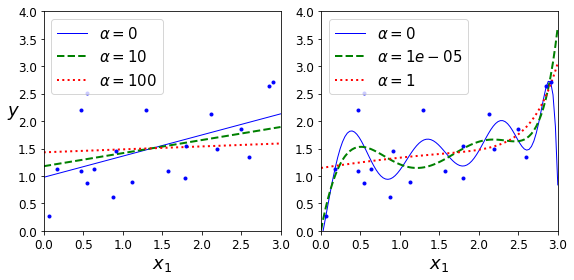

In [132]:
from sklearn.linear_model import Ridge
plt.figure(figsize=(8, 4))
plt.subplot(121)
plot_model(Ridge, polynomial=False, alphas=(0, 10, 100), random_state=42)
plt.ylabel('$y$', rotation=0, fontsize=18)
plt.subplot(122)
plot_model(Ridge, polynomial=True, alphas=(0, 10**-5, 1), random_state=42)

save_fig("ridge_regression_plot")
plt.show()

In [133]:
# closed-form solution
from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha=1, solver="cholesky", random_state=42)
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[1.55071465]])

In [137]:
sgd_reg = SGDRegressor(max_iter=50, tol=-np.infty, penalty='l2', random_state=42) # max_iter tol要有 不然有warning
sgd_reg.fit(X, y.ravel()) # column-vector -> 1d array
sgd_reg.predict([[1.5]])

array([1.49905184])

Lasso回归的损失函数 $J(\boldsymbol\theta)=MSE(\boldsymbol\theta)+\alpha\sum_{i=1}^{n}|\theta_i|$　（ｗ的一范数）
* lasso的一个特点是会消除重要程度最低的特征的权值(i.e. set to 0)
* 下图中，$\alpha=e^{-7}$对应的拟合曲线中，**高阶**特征权值基本上都是0，像条抛物线，可以认为模型自动进行了特征筛选，输出了稀疏模型（大部分权值都是0）

saving figure lasso_regression_plot


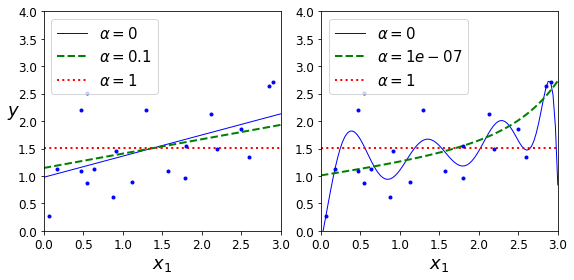

In [138]:
from sklearn.linear_model import Lasso

plt.figure(figsize=(8,4))
plt.subplot(121)
plot_model(Lasso, polynomial=False, alphas=(0, 0.1, 1), random_state=42)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(122)
plot_model(Lasso, polynomial=True, alphas=(0, 10**-7, 1), tol=1, random_state=42)

save_fig("lasso_regression_plot")
plt.show()

In [139]:
from sklearn.linear_model import Lasso
lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X, y)
lasso_reg.predict([[1.5]]) # a matrix

array([1.53788174])

Elastic Net损失函数　 $J(\boldsymbol\theta)=MSE(\boldsymbol\theta)+r\alpha\sum_{i\,=\,}^{n}|\theta_i|+\frac{1-r}{2}\alpha\sum_{i\,=\,1}^{n}\theta_i^2$　Lasso和Ridge的折中形式
* Lasso和Elastic Net都可以把不重要的特征的权值设为0
* 当特征数多于训练实例or一些特征之间强相关，Elastic Net预测性能更好

In [ ]:
from sklearn.linear_model import ElasticNet
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42) # l1_ration: r, 混合比例
elastic_net.fit(X, y)
elastic_net.predict([[1.5]])

saving figure early_stopping_plot


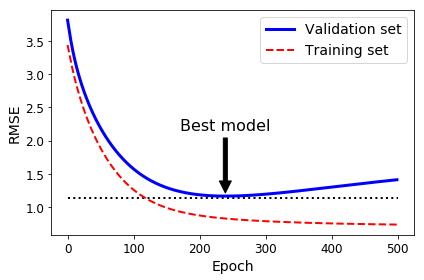

In [140]:
# early stopping in training
np.random.seed(42)
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 2 + X + 0.5 * X**2 + np.random.randn(m, 1)

X_train, X_val, y_train, y_val = train_test_split(X[:50], y[:50].ravel(), test_size=0.5, random_state=10)

poly_scaler = Pipeline([
        ("poly_features", PolynomialFeatures(degree=90, include_bias=False)),
        ("std_scaler", StandardScaler()),
    ])

X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled = poly_scaler.transform(X_val) # 训练集上fit一次就ok 直接transform验证集

sgd_reg = SGDRegressor(max_iter=1, # 只走一步
                       tol=-np.infty,
                       penalty=None,
                       eta0=0.0005,
                       warm_start=True, # 保留结果 下次接着用
                       learning_rate="constant",
                       random_state=42)

n_epochs = 500
train_errors, val_errors = [], []
for epoch in range(n_epochs):
    sgd_reg.fit(X_train_poly_scaled, y_train)
    y_train_predict = sgd_reg.predict(X_train_poly_scaled)
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    train_errors.append(mean_squared_error(y_train, y_train_predict))
    val_errors.append(mean_squared_error(y_val, y_val_predict))

best_epoch = np.argmin(val_errors)
best_val_rmse = np.sqrt(val_errors[best_epoch])

plt.annotate('Best model',
             xy=(best_epoch, best_val_rmse),
             xytext=(best_epoch, best_val_rmse + 1),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize=16,
            )

best_val_rmse -= 0.03  # just to make the graph look better
plt.plot([0, n_epochs], [best_val_rmse, best_val_rmse], "k:", linewidth=2)
plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="Validation set")
plt.plot(np.sqrt(train_errors), "r--", linewidth=2, label="Training set")
plt.legend(loc="upper right", fontsize=14)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("RMSE", fontsize=14)
save_fig("early_stopping_plot")
plt.show()

In [141]:
# same
from sklearn.base import clone
sgd_reg = SGDRegressor(max_iter=1, tol=-np.infty, warm_start=True, penalty=None,
                       learning_rate="constant", eta0=0.0005, random_state=42)

minimum_val_error = float("inf")
best_epoch = None
best_model = None
for epoch in range(1000):
    sgd_reg.fit(X_train_poly_scaled, y_train)  # continues where it left off
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    val_error = mean_squared_error(y_val, y_val_predict)
    if val_error < minimum_val_error:
        minimum_val_error = val_error
        best_epoch = epoch
        best_model = clone(sgd_reg)

In [142]:
best_epoch, best_model

(239,
 SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
        eta0=0.0005, fit_intercept=True, l1_ratio=0.15,
        learning_rate='constant', loss='squared_loss', max_iter=1,
        n_iter=None, n_iter_no_change=5, penalty=None, power_t=0.25,
        random_state=42, shuffle=True, tol=-inf, validation_fraction=0.1,
        verbose=0, warm_start=True))

In [143]:
t1a, t1b, t2a, t2b = -1, 3, -1.5, 1.5

# ignoring bias term
t1s = np.linspace(t1a, t1b, 500)
t2s = np.linspace(t2a, t2b, 500)
t1, t2 = np.meshgrid(t1s, t2s)
T = np.c_[t1.ravel(), t2.ravel()]
Xr = np.array([[-1, 1], [-0.3, -1], [1, 0.1]])
yr = 2 * Xr[:, :1] + 0.5 * Xr[:, 1:]

J = (1/len(Xr) * np.sum((T.dot(Xr.T) - yr.T)**2, axis=1)).reshape(t1.shape)

N1 = np.linalg.norm(T, ord=1, axis=1).reshape(t1.shape)
N2 = np.linalg.norm(T, ord=2, axis=1).reshape(t1.shape)

t_min_idx = np.unravel_index(np.argmin(J), J.shape)
t1_min, t2_min = t1[t_min_idx], t2[t_min_idx]

t_init = np.array([[0.25], [-1]])

saving figure lasso_vs_ridge_plot


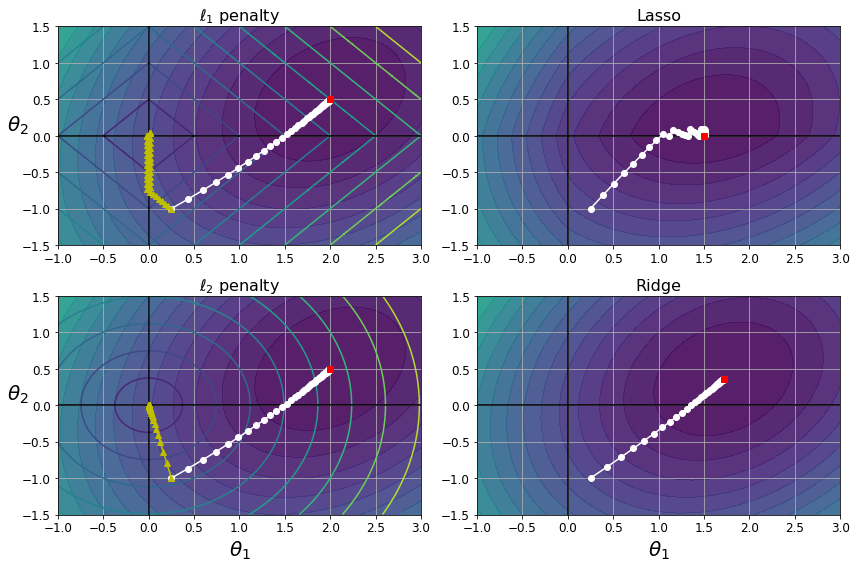

In [144]:
def bgd_path(theta, X, y, l1, l2, core = 1, eta = 0.1, n_iterations = 50):
    path = [theta]
    for iteration in range(n_iterations):
        gradients = core * 2/len(X) * X.T.dot(X.dot(theta) - y) + l1 * np.sign(theta) + 2 * l2 * theta

        theta = theta - eta * gradients
        path.append(theta)
    return np.array(path)

plt.figure(figsize=(12, 8))
for i, N, l1, l2, title in ((0, N1, 0.5, 0, "Lasso"), (1, N2, 0,  0.1, "Ridge")):
    JR = J + l1 * N1 + l2 * N2**2
    
    tr_min_idx = np.unravel_index(np.argmin(JR), JR.shape)
    t1r_min, t2r_min = t1[tr_min_idx], t2[tr_min_idx]

    levelsJ=(np.exp(np.linspace(0, 1, 20)) - 1) * (np.max(J) - np.min(J)) + np.min(J)
    levelsJR=(np.exp(np.linspace(0, 1, 20)) - 1) * (np.max(JR) - np.min(JR)) + np.min(JR)
    levelsN=np.linspace(0, np.max(N), 10)
    
    path_J = bgd_path(t_init, Xr, yr, l1=0, l2=0)
    path_JR = bgd_path(t_init, Xr, yr, l1, l2)
    path_N = bgd_path(t_init, Xr, yr, np.sign(l1)/3, np.sign(l2), core=0)

    plt.subplot(221 + i * 2)
    plt.grid(True)
    plt.axhline(y=0, color='k')
    plt.axvline(x=0, color='k')
    plt.contourf(t1, t2, J, levels=levelsJ, alpha=0.9)
    plt.contour(t1, t2, N, levels=levelsN)
    plt.plot(path_J[:, 0], path_J[:, 1], "w-o")
    plt.plot(path_N[:, 0], path_N[:, 1], "y-^")
    plt.plot(t1_min, t2_min, "rs")
    plt.title(r"$\ell_{}$ penalty".format(i + 1), fontsize=16)
    plt.axis([t1a, t1b, t2a, t2b])
    if i == 1:
        plt.xlabel(r"$\theta_1$", fontsize=20)
    plt.ylabel(r"$\theta_2$", fontsize=20, rotation=0)

    plt.subplot(222 + i * 2)
    plt.grid(True)
    plt.axhline(y=0, color='k')
    plt.axvline(x=0, color='k')
    plt.contourf(t1, t2, JR, levels=levelsJR, alpha=0.9)
    plt.plot(path_JR[:, 0], path_JR[:, 1], "w-o")
    plt.plot(t1r_min, t2r_min, "rs")
    plt.title(title, fontsize=16)
    plt.axis([t1a, t1b, t2a, t2b])
    if i == 1:
        plt.xlabel(r"$\theta_1$", fontsize=20)

save_fig("lasso_vs_ridge_plot")
plt.show()

####  Logistic Regression
* 计算特征的加权和+偏差值 -> logistic func.
* 预测的概率：$\hat{p}=h_{\boldsymbol\theta}(\mathbf{x})=\sigma(\mathbf{x}^{T}\boldsymbol\theta)$
* 预测的结果：
$\hat{y}=
\begin{cases} 
0& \text{if } \hat{p}<0.5 \\
1& \text{if } \hat{p}\ge0.5
\end{cases}
$　即取决于$t=\mathbf{x}^T\boldsymbol{\theta}$的符号，t也叫做logit，来自于logit func: logit(p)=log(p/(1-p))(logistic func.的逆函数logit(p),也叫log-odds（positive和negative类的预测概率的比值的对数）
* 训练目标：找到参数向量$\boldsymbol\theta$使得对应positive实例给出高的概率，neg.低概率
* 损失函数：对于一个实例，
$c(\boldsymbol\theta)=
\begin{cases}
-log(\hat{y}) & \text{if y=1} \\
-log(1-\hat{y}) & \text{if y=0}
\end{cases}
$（预测正确时，$-\lim\limits_{t\to1^{-}}log(t)=0^{+}$，反之很大
* 损失函数在整个训练集上的平均损失值(log loss): $J(\boldsymbol\theta)=-\frac{1}{m}\sum_{i=1}^{m}\big[y^{(i)}log(\hat{y}^{(i)})+(1-y^{(i)})log(1-\hat{y}^{(i)})\big]$ []中第一项针对tag是1的实例，第二项针对的是tag是0的实例，求和后取平均值作为损失值，该loss func没有闭式解，但是是convex函数（任意两点连线不和曲线相交），使用SGD等优化算法可以求得全局最优点
* loss func.的偏导数：$\frac{\partial}{\partial\theta_j}=\frac{1}{m}\sum\limits_{i=1}^{m}(\sigma(\boldsymbol\theta^{T}\boldsymbol{x}^{(i)}-y^{(i)})x_j^{(i)}$, 对每个实例，计算预测偏差和第j个特征的值，然后计算在整个训练集上的平均值。SGD则每次选择一个instance更新$\boldsymbol\theta$值，mini-batch SGD则在mini-batch上计算并更新$\boldsymbol\theta$

#### LR的决策边界
iris dataset(鸢尾花数据集): 包含了150个、三种不同的鸢尾花（Iris Setosa(山鸢尾)、Iris Versicolour(杂色鸢尾),以及Iris Virginica(维吉尼亚鸢尾）的sepal（萼片）、petal（花瓣）的长度、宽度值
建立一个分类器，仅根据花瓣的宽度特征来确定是不是iris virginica

In [158]:
from sklearn.datasets import load_iris
iris = load_iris() # dic-like data
list(iris.keys())

['data', 'target', 'target_names', 'DESCR', 'feature_names', 'filename']

In [164]:
# info. of the dataset
iris['data'].shape # (150, 4)
print(iris['target_names'])
print(iris['feature_names'])
print(iris['filename'])

['setosa' 'versicolor' 'virginica']
['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
/Users/chris/tensorflow/venv/lib/python3.6/site-packages/sklearn/datasets/data/iris.csv


In [147]:
print(iris.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

In [155]:
X = iris['data'][:, 3:] # if[-1] -> (150,)(array) [:, 3:] -> (150, 1)(column vector)
y = (iris['target'] == 2).astype(np.int)

In [156]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(solver='liblinear', random_state=42)
log_reg.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=42, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

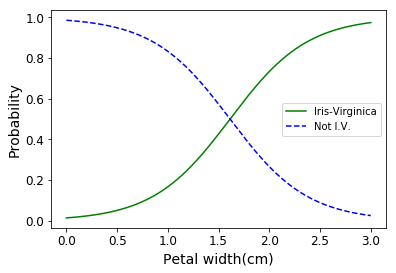

In [172]:
# iris['data'][:, -1].max() 2.5
# 决策边界p=0.5 大概在1.6cm处 
X_new = np.linspace(0, 3, 1000).reshape(-1,1)
y_proba = log_reg.predict_proba(X_new) # (1000, 2), col1: not iv col2: iv
plt.plot(X_new, y_proba[:, 1], 'g-', label='Iris-Virginica')
plt.plot(X_new, y_proba[:, 0], 'b--', label='Not I.V.')
plt.xlabel('Petal width(cm)')
plt.ylabel('Probability')
plt.legend(loc='best')

In [194]:
print(decision_boundary)
log_reg.predict([[1.62], [1.5]])

[1.61561562]


array([1, 0])

saving figure logistic_regression_plot


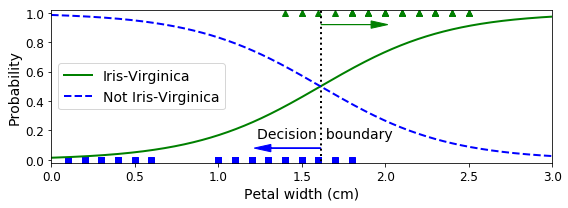

In [191]:
# pretty pic.
decision_boundary = X_new[y_proba[:, 1] >= 0.5][0]
plt.figure(figsize=(8, 3))
plt.plot(X[y==0], y[y==0], "bs") # bs for blue square, 不是IV的instance的petal length
plt.plot(X[y==1], y[y==1], "g^") # g^ for green triangle 是IV的instance的petal length
plt.plot([decision_boundary, decision_boundary], [-1, 2], "k:", linewidth=2)
plt.plot(X_new, y_proba[:, 1], "g-", linewidth=2, label="Iris-Virginica")
plt.plot(X_new, y_proba[:, 0], "b--", linewidth=2, label="Not Iris-Virginica")
plt.text(decision_boundary+0.02, 0.15, "Decision  boundary", fontsize=14, color="k", ha="center")
# delta_y, delta_x, delta_y_head, fc: head color ec: line color
plt.arrow(decision_boundary, 0.08, -0.3, 0, head_width=0.05, head_length=0.1, fc='b', ec='b')
plt.arrow(decision_boundary, 0.92, 0.3, 0, head_width=0.05, head_length=0.1, fc='g', ec='g')
plt.xlabel("Petal width (cm)", fontsize=14)
plt.ylabel("Probability", fontsize=14)
plt.legend(loc="center left", fontsize=14)
plt.axis([0, 3, -0.02, 1.02])
save_fig("logistic_regression_plot")
plt.show()

saving figure logistic_regression_contour_plot


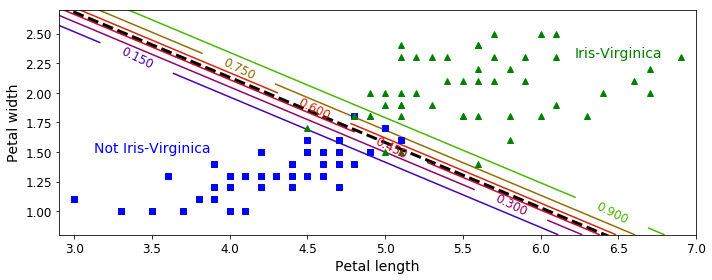

In [214]:
# 选择花瓣长度和宽度两个特征来分类，线性决策边界
# LR作为线性模型，同样可以用l2、l2正规方法来约束，scikit里面默认添加了l2约束，对应的超参数是C(alpha's inverse)，C越大，约束越弱
from sklearn.linear_model import LogisticRegression

X = iris["data"][:, (2, 3)]  # petal length, petal width
y = (iris["target"] == 2).astype(np.int)

log_reg = LogisticRegression(solver="liblinear", C=10**10, random_state=42)
log_reg.fit(X, y)

# meshgrid: 画网格
x0, x1 = np.meshgrid(
        np.linspace(2.9, 7, 500).reshape(-1, 1), # 不reshape也一样，都是（200，500）
        np.linspace(0.8, 2.7, 200).reshape(-1, 1),
    ) # x0的每个元素是[2.9, 7]数组，x1每个元素是固定的y，合起来形成网格点
X_new = np.c_[x0.ravel(), x1.ravel()]

y_proba = log_reg.predict_proba(X_new)

plt.figure(figsize=(10, 4))
plt.plot(X[y==0, 0], X[y==0, 1], "bs") # X[y==0, 0]先筛选 再提取特征
plt.plot(X[y==1, 0], X[y==1, 1], "g^")

zz = y_proba[:, 1].reshape(x0.shape) # x0 shape (200, 500)
contour = plt.contour(x0, x1, zz, cmap=plt.cm.brg) # 画等高线（预测概率），不同颜色表示不同的pm，brg即 brue->red->green(P up)


left_right = np.array([2.9, 7]) # x val of boundary
# decision boundry: theta_0 + theta_1*x_1 + theta_2*x_2 = 0, .conef_:(1,2), .intercept_: (1,)
boundary = -(log_reg.coef_[0][0] * left_right + log_reg.intercept_[0]) / log_reg.coef_[0][1]

plt.clabel(contour, inline=1, fontsize=12) # 线上加概率值
plt.plot(left_right, boundary, "k--", linewidth=3)

plt.text(3.5, 1.5, "Not Iris-Virginica", fontsize=14, color="b", ha="center")
plt.text(6.5, 2.3, "Iris-Virginica", fontsize=14, color="g", ha="center")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.axis([2.9, 7, 0.8, 2.7])
save_fig("logistic_regression_contour_plot")
plt.show()

#### Softmax Regression (multinominal logistic regression)
* LR的扩展，用于多分类问题，但是一次只能预测一类，不是multioutput，so不可以用来识别图片中的多个人
* 损失函数[cross entropy](https://www.youtube.com/watch?v=ErfnhcEV1O8): $J(\Theta)=-\frac{1}{m}\sum_{i=1}^{m}\sum_{k=1}^{K}y_k^{(i)}log(\hat{p}_k^{(i)})$　K: class, m: instance, K=2时和LR的log loss一样
* Softmax score for class k: $s_k(\mathbf{x})=\mathbf{x}^T\boldsymbol{\theta}^{(k)}$　每个类都有对应的参数向量$\boldsymbol{\theta}^{(k)}$（参数矩阵$\Theta$中的行向量）
* 每个class对应的得分$\mathbf{s}(\mathbf{x})_k$扔到softmax函数中就得到实例属于每个class的概率$\hat{p_k}=\sigma({\mathbf{s}(\mathbf{x}))_k}=\large{\frac{exp(s_k(\mathbf{x}))}{\sum_{j=1}^{K}exp(s_j(\mathbf{x}))}}$
* softmax回归的预测类别: $\hat{y}=\mathop{argmax}\limits_{k}\sigma(\mathbf{s}(\mathbf{x}))_k=\mathop{argmax}\limits_{k}s_k(\mathbf{x})=\mathop{argmax}\limits_{k}\big(\normalsize(\boldsymbol{\theta}^{(k)})^{T}\mathbf{x})$　argmax 返回的是让函数取得最大值的变量的值

In [226]:
X = iris["data"][:, (2, 3)]  # petal length, petal width
y = iris["target"]

softmax_reg = LogisticRegression(multi_class="multinomial",solver="lbfgs", C=10, random_state=42)
softmax_reg.fit(X, y)

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=None, penalty='l2', random_state=42, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

saving figure softmax_regression_contour_plot


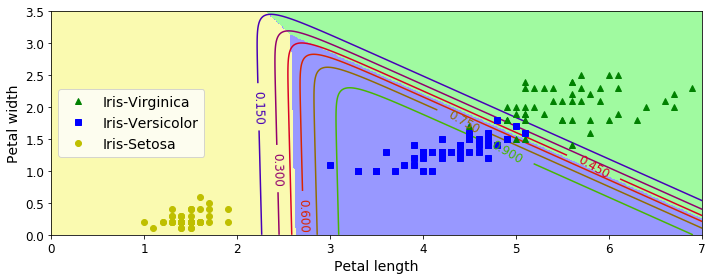

In [233]:
x0, x1 = np.meshgrid(
        np.linspace(0, 8, 500).reshape(-1, 1),
        np.linspace(0, 3.5, 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]


y_proba = softmax_reg.predict_proba(X_new)
y_predict = softmax_reg.predict(X_new)

zz1 = y_proba[:, 1].reshape(x0.shape)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y==2, 0], X[y==2, 1], "g^", label="Iris-Virginica")
plt.plot(X[y==1, 0], X[y==1, 1], "bs", label="Iris-Versicolor")
plt.plot(X[y==0, 0], X[y==0, 1], "yo", label="Iris-Setosa")

from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0']) # 黄 紫 绿

plt.contourf(x0, x1, zz, cmap=custom_cmap) # contourf会根据预测的class对等高线间的区域进行填充，上面的三种颜色三个class

contour = plt.contour(x0, x1, zz1, cmap=plt.cm.brg) # 画等高线 0.15 - 0.75
plt.clabel(contour, inline=1, fontsize=12)

plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="center left", fontsize=14)
plt.axis([0, 7, 0, 3.5])

save_fig("softmax_regression_contour_plot")
plt.show()

In [ ]:
print(softmax_reg.predict([[5, 2]]))
print(softmax_reg.predict_proba([[5, 2]]))
np.argmax(softmax_reg.predict_proba([[5, 2]]))

### 实现softmax regression和early stopping（no scikit-learn）

In [241]:
X = iris['data'][:, (2,3)]
y = iris['target']


In [243]:
X_with_bias = np.c_[np.ones([len(X), 1]), X]

In [246]:
np.random.seed(2042)

In [247]:
test_ratio = 0.2
val_ratio = 0.2 # validation set
total_size = len(X)

test_size = int(total_size * test_ratio)
val_size = int(total_size * val_ratio)
train_size = total_size - test_size - val_size

rnd_idx = np.random.permutation(total_size)

X_train = X_with_bias[rnd_idx[:train_size]]
y_train = y[rnd_idx[:train_size]]
X_val = X_with_bias[rnd_idx[train_size:-test_size]]
y_val = y[rnd_idx[train_size:-test_size]]
X_test = X_with_bias[rnd_idx[-test_size:]]
y_test = y[rnd_idx[-test_size:]]

target => one-hot label

In [262]:
def to_one_hot(y):
    n_classes = np.max(y) + 1
    m = len(y)
    Y_one_hot = np.zeros([m, n_classes])
    Y_one_hot[np.arange(m), y] = 1 # 不可以用 Y_one_hot[:, y] -> all 1
    return Y_one_hot

In [264]:
to_one_hot(y_train[:10]).shape

(10, 3)

In [265]:
Y_train_one_hot = to_one_hot(y_train)
Y_val_one_hot = to_one_hot(y_val)
Y_test_one_hot = to_one_hot(y_test)

#### 实现softmax函数: $\sigma(\mathbf{s}(\mathbf{x}))_k=\large{\frac{exp(s_k(\mathbf{x}))}{\sum\limits_{j=1}^{K}exp(s_j(\mathbf{x}))}}$

In [267]:
def softmax(logits):
    exps = np.exp(logits)
    exp_sums = np.sum(exps, axis=1, keepdims=1)
    return exps / exp_sums

In [268]:
n_inputs = X_train.shape[1] # 3 = 2个特征 + 1个偏差项
n_outputs = len(np.unique(y_train)) # 3 iris classes

Now here comes the hardest part: training! Theoretically, it's simple: it's just a matter of translating the math equations into Python code. But in practice, it can be quite tricky: in particular, it's easy to mix up the order of the terms, or the indices. You can even end up with code that looks like it's working but is actually not computing exactly the right thing. When unsure, you should write down the shape of each term in the equation and make sure the corresponding terms in your code match closely. It can also help to evaluate each term independently and print them out. The good news it that you won't have to do this everyday, since all this is well implemented by Scikit-Learn, but it will help you understand what's going on under the hood.
（训练过程即将数学公式转化成python代码，实际使用时尤其要注意方程中项的阶数、索引值、每一项的shape）
<br>**损失函数**：

$J(\mathbf{\Theta}) =
- \dfrac{1}{m}\sum\limits_{i=1}^{m}\sum\limits_{k=1}^{K}{y_k^{(i)}\log\left(\hat{p}_k^{(i)}\right)}$

上式**梯度**为：

$\nabla_{\mathbf{\theta}^{(k)}} \, J(\mathbf{\Theta}) = \dfrac{1}{m} \sum\limits_{i=1}^{m}{ \left ( \hat{p}^{(i)}_k - y_k^{(i)} \right ) \mathbf{x}^{(i)}}$

注意，当$\hat{p}_k^{(i)} = 0$时，$\log\left(\hat{p}_k^{(i)}\right)$ 无法计算。 加上一个很小的值 $\epsilon$ 到$\log\left(\hat{p}_k^{(i)}\right)$ 可以避免出现 **`nan`** 值。

1. 照搬上面的公式

In [292]:
# np.random.seed()
eta = 0.01
n_iterations = 5001
m = len(X_train)
epsilon = 1e-7

Theta = np.random.randn(n_inputs, n_outputs) # 随机化初始权值

for iteration in range(n_iterations):
    logits = X_train.dot(Theta) # 计算scores: (90, 3).dot(3, 3) -> (90, 3)
    Y_proba = softmax(logits) # 将scores -> probability, shape不变, (90, 3)
    # 损失函数，注意这儿不是矩阵运算，(90, 3) * (90 * 3) -> (90, 3) 相同位置上的元素相乘
    loss = -np.mean(np.sum(Y_train_one_hot * np.log(Y_proba+epsilon), axis=1)) # (90, 3) sum->(90,) mean-> scaler loss
    error = Y_proba - Y_train_one_hot # (90, 3)
    if iteration % 500 == 0:
        print(iteration, loss)
    gradients = 1 / m * X_train.T.dot(error) # (3, 90).dot(90, 3) -> (3, 3), sum是沿着长边运算(点积)
    Theta = Theta - eta * gradients

0 2.0565547137130737
500 0.9590884500750482
1000 0.7522119408311858
1500 0.634634070253511
2000 0.5632349593094211
2500 0.5157337918948429
3000 0.48152668332004894
3500 0.45533079930565706
4000 0.4343149105117011
4500 0.41685051722446836
5000 0.40194126430509897


In [296]:
np.sum([[3,1,1], [3,2,0]], axis=1) # reduce dim

array([5, 5])

In [298]:
# 验证集上的表现
logits = X_val.dot(Theta)
y_proba = softmax(logits)
y_pred = np.argmax(y_proba, axis=1) # reduce dim. like np.sum, np.mean...
acc = np.mean(y_pred==y_val)
acc

0.9666666666666667

In [300]:
np.r_[[[3,2,1]], [[3,1,1], [4,0,2]]]

array([[3, 2, 1],
       [3, 1, 1],
       [4, 0, 2]])

2. 加上$\ell_2$正则项，增加alpha来对权值进行约束

In [301]:
eta = 0.1
n_iterations = 5001
m = len(X_train)
epsilon = 1e-7
alpha = 0.1  # regularization hyperparameter

Theta = np.random.randn(n_inputs, n_outputs)

for iteration in range(n_iterations):
    logits = X_train.dot(Theta)
    Y_proba = softmax(logits)
    xentropy_loss = -np.mean(np.sum(Y_train_one_hot * np.log(Y_proba + epsilon), axis=1)) # 交叉熵
    l2_loss = 1/2 * np.sum(np.square(Theta[1:])) # 第一个feature偏差项不加约束
    loss = xentropy_loss + alpha * l2_loss # 加上 l2 惩罚项
    error = Y_proba - Y_train_one_hot
    if iteration % 500 == 0:
        print(iteration, loss)
    # row1是0(因为没有约束), 剩下的是l2惩罚项的导数alpha*weights
    gradients = 1/m * X_train.T.dot(error) + np.r_[np.zeros([1, n_outputs]), alpha * Theta[1:]]
    Theta = Theta - eta * gradients

0 5.086692526305268
500 0.5117253414122714
1000 0.49679885358373177
1500 0.492114970307364
2000 0.4902427087824988
2500 0.48944820838695624
3000 0.48910115676822097
3500 0.48894694929832594
4000 0.4888776932149317
4500 0.4888463746788424
5000 0.4888321479321895


In [304]:
# 加上l2后，loss变大了，但是预测性能更好了
logits = X_val.dot(Theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)

accuracy_score = np.mean(y_predict == y_val)
accuracy_score

1.0

3. 加上early stopping，当验证集上的loss增加时，停止训练

In [306]:
eta = 0.1 
n_iterations = 5001
m = len(X_train)
epsilon = 1e-7
alpha = 0.1  # regularization hyperparameter
best_loss = np.infty

Theta = np.random.randn(n_inputs, n_outputs)

for iteration in range(n_iterations):
    logits = X_train.dot(Theta)
    Y_proba = softmax(logits)
    xentropy_loss = -np.mean(np.sum(Y_train_one_hot * np.log(Y_proba + epsilon), axis=1))
    l2_loss = 1/2 * np.sum(np.square(Theta[1:]))
    loss = xentropy_loss + alpha * l2_loss
    error = Y_proba - Y_train_one_hot
    gradients = 1/m * X_train.T.dot(error) + np.r_[np.zeros([1, n_outputs]), alpha * Theta[1:]]
    Theta = Theta - eta * gradients

    logits = X_val.dot(Theta)
    Y_proba = softmax(logits)
    xentropy_loss = -np.mean(np.sum(Y_val_one_hot * np.log(Y_proba + epsilon), axis=1))
    l2_loss = 1/2 * np.sum(np.square(Theta[1:]))
    loss = xentropy_loss + alpha * l2_loss
    if iteration % 500 == 0:
        print(iteration, loss)
    if loss < best_loss:
        best_loss = loss
    else:
        print(iteration - 1, best_loss)
        print(iteration, loss, "early stopping!")
        break

0 2.835260134594504
500 0.5595390751957228
1000 0.5399183571743137
1500 0.5345276199081139
2000 0.53291227096123
2500 0.5325535357411335
2621 0.5325446906738972
2622 0.5325446913757405 early stopping!


In [309]:
logits = X_val.dot(Theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)

accuracy_score = np.mean(y_predict == y_val)
accuracy_score

1.0

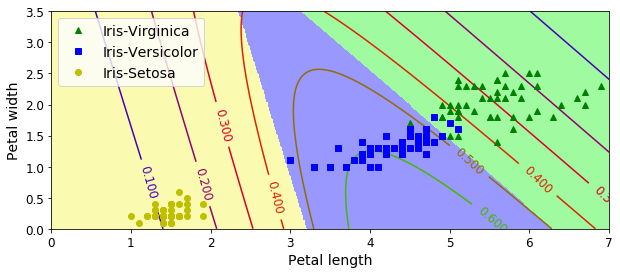

In [318]:
x0, x1 = np.meshgrid(
        np.linspace(0, 8, 500).reshape(-1, 1),
        np.linspace(0, 3.5, 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]
X_new_with_bias = np.c_[np.ones([len(X_new), 1]), X_new]

logits = X_new_with_bias.dot(Theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)

zz1 = Y_proba[:, 1].reshape(x0.shape)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y==2, 0], X[y==2, 1], "g^", label="Iris-Virginica")
plt.plot(X[y==1, 0], X[y==1, 1], "bs", label="Iris-Versicolor")
plt.plot(X[y==0, 0], X[y==0, 1], "yo", label="Iris-Setosa")

from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0']) # contourf里面填充的颜色

plt.contourf(x0, x1, zz, cmap=custom_cmap) # 根据分类类别填充颜色
contour = plt.contour(x0, x1, zz1, cmap=plt.cm.brg) # 根据预测概率(是vercicolor的概率)画等高线，p增加，颜色从 blue-red-green
plt.clabel(contour, inline=1, fontsize=12)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=14)
plt.axis([0, 7, 0, 3.5])
plt.show()

#### 测试集上的表现

In [319]:
logits = X_test.dot(Theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)

accuracy_score = np.mean(y_predict == y_test)
accuracy_score

0.9333333333333333